# Stochastic optimisation

This example optimises a single node with only a wind, solar, gas and lignite generator under uncertainty about the gas price.

In Stage 1 decisions are made about capacities of the generators while the gas price is unknown.


First we solve assuming knowledge about the gas price, then stochastically according to the probability distribution of gas prices.

We then show that the average total cost of the system of the stochastically optimised capacities is lower than the means of the solutions from the deterministically determined capacities.





Required data:

i) Solar time series "ninja_pv_europe_v1.1_sarah.csv" from "PV v1.1 Europe" https://www.renewables.ninja/downloads

ii) Wind time series "ninja_wind_europe_v1.1_current_on-offshore.csv" from "Wind v1.1 Europe" https://www.renewables.ninja/downloads

In [1]:
import requests
from io import StringIO

import pypsa, pandas as pd, numpy as np
import matplotlib.pyplot as plt

from xarray import DataArray
from pypsa.optimization.common import reindex
from pypsa.descriptors import get_switchable_as_dense as get_as_dense
from pypsa.descriptors import nominal_attrs
from pypsa.descriptors import (
    additional_linkports,
    expand_series,
    get_activity_mask,
    get_bounds_pu,
)
from linopy.expressions import LinearExpression, merge

idx = pd.IndexSlice
%matplotlib inline

### Retrieve PV & Wind data

In [2]:
datasets = {
    "url_pv": 'https://www.renewables.ninja/country_downloads/DE/ninja_pv_country_DE_sarah_corrected.csv',
    "url_wind": 'https://www.renewables.ninja/country_downloads/DE/ninja_wind_country_DE_current-merra-2_corrected.csv'
}

In [3]:

# Initialize empty dict to store data
data = {}

# Iterate over datasets
for name, url in datasets.items():
    response = requests.get(url)
    response.raise_for_status()  # Raise an HTTPError if the HTTP request returned an unsuccessful status code

    # Read the content using pandas
    csv_content = response.content.decode('utf-8')
    df = pd.read_csv(StringIO(csv_content), skiprows=2, parse_dates=['time'], index_col='time')

    # Extract the 'national' column and store it in the data dictionary
    data[name] = df['national']


In [4]:
solar_pu = data["url_pv"]
wind_pu = data["url_wind"]

In [5]:
# solar_pu[solar_pu.index.year == 2013].describe()

# Major settings

In [6]:
scenarios = ["low","med","high"]

#this just determines the default scenario when building stochastic model
base_scenario = "low"

#in EUR/MWh_th
gas_prices = {"low" : 50,
              "med" : 100,
              "high" : 400}

probability = {"low" : 0.4,
               "med" : 0.3,
               "high" : 0.3}


In [7]:
#years for weather data (solar is 1985-2015 inclusive, wind is 1980-2019)
year_start = 2015
year_end = 2015

#1 is hourly, 3 is 3-hourly
frequency = 3

#Fixed load in MW
load = 1

#change to cbc or glpk for open-source solvers
solver_name = "gurobi"

cts = ["DE"]

## Read in data

In [8]:
assumptions = pd.DataFrame(columns=["FOM","discount rate","efficiency","investment","lifetime"],
                           index=["default","onshore wind","utility solar PV","gas CCGT", "lignite"])

assumptions.at["default","FOM"] = 3.
assumptions.at["default","discount rate"] = 0.03
assumptions.at["default","lifetime"] = 25

assumptions.at["onshore wind","investment"] = 2e6
assumptions.at["utility solar PV","investment"] = 10e5
assumptions.at["gas CCGT","investment"] = 7e5
assumptions.at["gas CCGT","efficiency"] = 0.6

assumptions.at["lignite","investment"] = 15e5
assumptions.at["lignite","efficiency"] = 0.3

#fill defaults
assumptions = assumptions.fillna({"FOM" : assumptions.at["default","FOM"],
                                  "discount rate" : assumptions.at["default","discount rate"],
                                  "lifetime" : assumptions.at["default","lifetime"]})

def annuity(lifetime,rate):
    if rate == 0.:
        return 1/lifetime
    else:
        return rate/(1. - 1. / (1. + rate)**lifetime)

#annualise investment costs, add FOM
assumptions["fixed"] = [(annuity(v["lifetime"],v["discount rate"])+v["FOM"]/100.)*v["investment"] for i,v in assumptions.iterrows()]

assumptions

,FOM,discount rate,efficiency,investment,lifetime,fixed
default,3.0,0.03,NaN,NaN,25,NaN
onshore wind,3.0,0.03,NaN,2000000.0,25,174855.742078
utility solar PV,3.0,0.03,NaN,1000000.0,25,87427.871039
gas CCGT,3.0,0.03,0.6,700000.0,25,61199.509727
lignite,3.0,0.03,0.3,1500000.0,25,131141.806559


## Required functions

In [9]:
#prepare base network (without stochastic optimisation)
def prepare_network(cts,gas_price):


    network = pypsa.Network()

    snapshots = pd.date_range("{}-01-01".format(year_start),"{}-12-31 23:00".format(year_end),
                              freq=str(frequency)+"H")

    network.set_snapshots(snapshots)

    network.snapshot_weightings = pd.Series(float(frequency),index=network.snapshots)
    
    for ct in cts:

        network.add("Bus",ct)
        network.add("Load",ct,
                    bus=ct,
                    p_set=load)

        network.add("Generator",ct+" solar",
                    bus=ct,
                    p_max_pu = solar_pu,
                    p_nom_extendable = True,
                    marginal_cost = 0.01, #Small cost to prefer curtailment to destroying energy in storage, solar curtails before wind
                    capital_cost = assumptions.at['utility solar PV','fixed'])

        network.add("Generator",ct+" wind",
                    bus=ct,
                    p_max_pu = wind_pu,
                    p_nom_extendable = True,
                    marginal_cost = 0.02, #Small cost to prefer curtailment to destroying energy in storage, solar curtails before wind
                    capital_cost = assumptions.at['onshore wind','fixed'])

        network.add("Generator",ct+" gas",
                    bus=ct,
                    p_nom_extendable = True,
                    efficiency=assumptions.at["gas CCGT","efficiency"],
                    marginal_cost = gas_price/assumptions.at["gas CCGT","efficiency"],
                    capital_cost = assumptions.at["gas CCGT","fixed"])
          
        network.add("Generator",ct+" lignite",
                    bus=ct,
                    p_nom_extendable = True,
                    efficiency=assumptions.at["lignite","efficiency"],
                    marginal_cost = 150,
                    capital_cost = assumptions.at["gas CCGT","fixed"])
          
                
    return network

In [10]:
# add additional operational scenarios to the base model
def prepare_stochastic_model(n):
    m = n.optimize.create_model()
    
    nonbase_scenarios = scenarios.copy()
    nonbase_scenarios.remove(base_scenario)
    
    
    #we only have generators in this example, which simplifies things
    c = "Generator"
    sns = n.snapshots
    attr = "p"
    active = None
    column = "bus"
    sign = 1
    ext_i = n.get_extendable_i(c)
    min_pu, max_pu = map(DataArray, get_bounds_pu(n, c, sns, ext_i, attr))
    capacity = n.model[f"{c}-{nominal_attrs[c]}"]
    
    
    for scenario in nonbase_scenarios:
        
        #add extra operational variables for each non-base scenario
        dispatch = m.add_variables(coords=m["Generator-p"].coords,
                                   name=f"Generator-p-{scenario}")
        dispatch = reindex(dispatch, c, ext_i)
        
        
        #add dispatch constraints
        lhs = dispatch - max_pu * capacity # instead of the tuple formulation
        m.add_constraints(lhs, "<=", 0, f"{c}-ext-{attr}-upper-{scenario}", active)
        
        lhs = dispatch - min_pu * capacity 
        m.add_constraints(lhs, ">=", 0, f"{c}-ext-{attr}-lower-{scenario}", active)
        
        #add nodal balance constraints
        exprs = []
        expr = DataArray(sign) * m[f"{c}-{attr}-{scenario}"]
        buses = n.df(c)[column].rename("Bus")
        expr = expr.groupby_sum(buses.to_xarray())
        exprs.append(expr)
        lhs = merge(exprs).reindex(
                Bus=n.buses.index, fill_value=LinearExpression.fill_value
                )
        rhs = (
            (-get_as_dense(n, "Load", "p_set", sns) * n.loads.sign)
            .groupby(n.loads.bus, axis=1)
            .sum()
            .reindex(columns=n.buses.index, fill_value=0)
        )
        rhs.index.name = "snapshot"
        rhs = DataArray(rhs)
        mask = None
        m.add_constraints(lhs, "=", rhs, f"Bus-nodal_balance-{scenario}", mask=mask)
    
    
    #define the new objective
    
    objective = []
    weighting = n.snapshot_weightings.objective
    weighting = weighting.loc[sns]
    cost = (
            get_as_dense(n, c, "marginal_cost", sns)
            .loc[:, lambda ds: (ds != 0).all()]
            .mul(weighting, axis=0)
        )
    
    for scenario in scenarios:
    
        cost_modified = cost.copy()
    
        if scenario == base_scenario:
            name = f"{c}-{attr}"
        else:
            name = f"{c}-{attr}-{scenario}"
            cost_modified["DE gas"] = cost_modified["DE gas"]*gas_prices[scenario]/gas_prices[base_scenario]
    
        operation = m[name].sel({"snapshot": sns, c: cost.columns})
        objective.append((operation * (probability[scenario]* cost_modified)).sum())
        
    ext_i = n.get_extendable_i(c)
    cost = n.df(c)["capital_cost"][ext_i]
    objective.append((capacity * cost).sum())
    
    m.objective = merge(objective)

In [11]:
# Check that network is created correctly:
# gas_price = 30
# n = prepare_network(cts,gas_price)

# First solve capacities for each scenario deterministically

In [12]:
results = None

for scenario in scenarios:


    gas_price = gas_prices[scenario]

    n = prepare_network(cts,gas_price)

    n.optimize(solver_name = solver_name)
    
    if results is None:
        results = pd.DataFrame(columns=n.generators.index)
        results.index.name = "scenario"
    
    results.loc[scenario] = n.generators.p_nom_opt

/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/hom

Set parameter TokenServer to value "ensys3.service.tu-berlin.de"
Read LP format model from file /tmp/linopy-problem-6ugjoofp.lp


Reading time = 0.02 seconds
obj: 26284 rows, 11684 columns, 45363 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: AMD Ryzen 7 PRO 5850U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 26284 rows, 11684 columns and 45363 nonzeros
Model fingerprint: 0x31498c5c
Coefficient statistics:
  Matrix range     [1e-04, 1e+00]
  Objective range  [3e-02, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 13045 rows and 1361 columns
Presolve time: 0.02s
Presolved: 13239 rows, 10323 columns, 30957 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 4
 AA' NZ     : 2.064e+04
 Factor NZ  : 8.452e+04 (roughly 10 MB of memory)
 Factor Ops : 5.691e+05 (less than 1 second per iteration)
 Threads    : 1

                  

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11684 primals, 26284 duals
Objective: 7.88e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future erro

Read LP format model from file /tmp/linopy-problem-59_6ue88.lp
Reading time = 0.03 seconds
obj: 26284 rows, 11684 columns, 45363 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: AMD Ryzen 7 PRO 5850U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 26284 rows, 11684 columns and 45363 nonzeros
Model fingerprint: 0x900cec03
Coefficient statistics:
  Matrix range     [1e-04, 1e+00]
  Objective range  [3e-02, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 13045 rows and 1361 columns
Presolve time: 0.02s
Presolved: 13239 rows, 10323 columns, 30957 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 4
 AA' NZ     : 2.064e+04
 Factor NZ  : 8.452e+04 (roughly 10 MB of memory)
 Factor Ops : 5.691e+05 (less t

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11684 primals, 26284 duals
Objective: 1.12e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future erro

Read LP format model from file /tmp/linopy-problem-sd29gpoj.lp
Reading time = 0.03 seconds
obj: 26284 rows, 11684 columns, 45363 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: AMD Ryzen 7 PRO 5850U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 26284 rows, 11684 columns and 45363 nonzeros
Model fingerprint: 0x9dab9265
Coefficient statistics:
  Matrix range     [1e-04, 1e+00]
  Objective range  [3e-02, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 13045 rows and 1361 columns
Presolve time: 0.02s
Presolved: 13239 rows, 10323 columns, 30957 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 4
 AA' NZ     : 2.064e+04
 Factor NZ  : 8.452e+04 (roughly 10 MB of memory)
 Factor Ops : 5.691e+05 (less t

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11684 primals, 26284 duals
Objective: 1.12e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(


In [13]:
results

Generator,DE solar,DE wind,DE gas,DE lignite
scenario,,,,
low,1.388503,0.00000,1.0,0.000000
med,1.631694,1.92419,0.0,0.986723
high,1.631694,1.92419,0.0,0.986723


# Now solve the full problem stochastically

In [14]:
gas_price = gas_prices[base_scenario]

n = prepare_network(cts, gas_price)

prepare_stochastic_model(n)

n.optimize.solve_model(solver_name = solver_name)

/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/hom

AttributeError: 'LinearExpression' object has no attribute 'groupby_sum'

In [12]:
results.loc["stochastic"] = n.generators.p_nom_opt

In [13]:
results

Generator,DE solar,DE wind,DE gas,DE lignite
scenario,,,,
low,1.388889,0.000000,1.000000,0.000000
med,1.701963,1.713573,0.000000,0.989311
high,1.701963,1.713573,0.000000,0.989311
stochastic,1.563657,1.418681,0.808106,0.939329


# Now test each set of capacities against realisations of the gas price

In [20]:
for scenario in scenarios:
    
    gas_price = gas_prices[scenario]
    n = prepare_network(cts,gas_price)
    n.generators.p_nom_extendable = False
    
    for capacity_scenario in results.index:
        n.generators.p_nom = results.loc[capacity_scenario,n.generators.index]
        
        print(n.generators.p_nom)
        
        n.optimize(solver_name = solver_name)
        
        results.at[capacity_scenario,f"gas-p-{scenario}"] = n.generators_t.p["DE gas"].sum()
        results.at[capacity_scenario,f"lignite-p-{scenario}"] = n.generators_t.p["DE lignite"].sum()

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:linopy.model: Solve linear problem using Gurobi solver
Writing constraints.:   0%|          | 0/3 [00:00<?, ?it/s]

Generator
DE solar      1.388889
DE wind       0.000000
DE gas        1.000000
DE lignite    0.000000
Name: p_nom, dtype: float64


Writing variables.: 100%|██████████| 1/1 [00:00<00:00, 87.50it/s]

Read LP format model from file /tmp/linopy-problem-8_bu152z.lp
Reading time = 0.03 seconds
obj: 26280 rows, 11680 columns, 35040 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 26280 rows, 11680 columns and 35040 nonzeros
Model fingerprint: 0x1723e37c
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 26280 rows and 11680 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0572394e+05   0.000000e+00   0.000000e+00      0s

Solved with primal simplex
Solved in 0 iterations and 0.02 seconds
Optimal objective  6.057239414e+05



INFO:linopy.model: Optimization successful. Objective value: 6.06e+05


Generator
DE solar      1.701963
DE wind       1.713573
DE gas        0.000000
DE lignite    0.989311
Name: p_nom, dtype: float64


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 1/1 [00:00<00:00, 86.86it/s]

Read LP format model from file /tmp/linopy-problem-dac_kq7s.lp
Reading time = 0.03 seconds
obj: 26280 rows, 11680 columns, 35040 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 26280 rows, 11680 columns and 35040 nonzeros
Model fingerprint: 0xf6b5ce20
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 2e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 26076 rows and 11068 columns
Presolve time: 0.02s
Presolved: 204 rows, 612 columns, 612 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 0.000e+00
 Factor NZ  : 2.040e+02
 Factor Ops : 2.040e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         


INFO:linopy.model: Optimization successful. Objective value: 6.41e+05


Generator
DE solar      1.701963
DE wind       1.713573
DE gas        0.000000
DE lignite    0.989311
Name: p_nom, dtype: float64


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 1/1 [00:00<00:00, 88.63it/s]

Read LP format model from file /tmp/linopy-problem-4n1ly91r.lp
Reading time = 0.03 seconds
obj: 26280 rows, 11680 columns, 35040 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 26280 rows, 11680 columns and 35040 nonzeros
Model fingerprint: 0xf6b5ce20
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 2e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 26076 rows and 11068 columns
Presolve time: 0.02s
Presolved: 204 rows, 612 columns, 612 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 0.000e+00
 Factor NZ  : 2.040e+02
 Factor Ops : 2.040e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         


INFO:linopy.model: Optimization successful. Objective value: 6.41e+05


Generator
DE solar      1.563657
DE wind       1.418681
DE gas        0.808106
DE lignite    0.939329
Name: p_nom, dtype: float64


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 1/1 [00:00<00:00, 88.76it/s]

Read LP format model from file /tmp/linopy-problem-lns63ww1.lp
Reading time = 0.03 seconds
obj: 26280 rows, 11680 columns, 35040 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 26280 rows, 11680 columns and 35040 nonzeros
Model fingerprint: 0x9975e0c0
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 24275 rows and 4435 columns
Presolve time: 0.02s
Presolved: 2005 rows, 7245 columns, 7245 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 0.000e+00
 Factor NZ  : 2.005e+03 (roughly 4 MBytes of memory)
 Factor Ops : 2.005e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter     


INFO:linopy.model: Optimization successful. Objective value: 4.07e+05
INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:linopy.model: Solve linear problem using Gurobi solver
Writing constraints.:   0%|          | 0/3 [00:00<?, ?it/s]

Generator
DE solar      1.388889
DE wind       0.000000
DE gas        1.000000
DE lignite    0.000000
Name: p_nom, dtype: float64


Writing variables.: 100%|██████████| 1/1 [00:00<00:00, 89.22it/s]

Read LP format model from file /tmp/linopy-problem-aykmojjt.lp
Reading time = 0.03 seconds
obj: 26280 rows, 11680 columns, 35040 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 26280 rows, 11680 columns and 35040 nonzeros
Model fingerprint: 0x0e3b915d
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 26280 rows and 11680 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2114330e+06   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.03 seconds
Optimal objective  1.211432968e+06



INFO:linopy.model: Optimization successful. Objective value: 1.21e+06


Generator
DE solar      1.701963
DE wind       1.713573
DE gas        0.000000
DE lignite    0.989311
Name: p_nom, dtype: float64


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 1/1 [00:00<00:00, 84.71it/s]

Read LP format model from file /tmp/linopy-problem-57hnz_b9.lp
Reading time = 0.03 seconds
obj: 26280 rows, 11680 columns, 35040 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 26280 rows, 11680 columns and 35040 nonzeros
Model fingerprint: 0xf81ec931
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 2e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 26076 rows and 11068 columns
Presolve time: 0.02s
Presolved: 204 rows, 612 columns, 612 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 0.000e+00
 Factor NZ  : 2.040e+02
 Factor Ops : 2.040e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         


INFO:linopy.model: Optimization successful. Objective value: 6.41e+05


Generator
DE solar      1.701963
DE wind       1.713573
DE gas        0.000000
DE lignite    0.989311
Name: p_nom, dtype: float64


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 1/1 [00:00<00:00, 89.77it/s]

Read LP format model from file /tmp/linopy-problem-5j1ukbct.lp
Reading time = 0.03 seconds
obj: 26280 rows, 11680 columns, 35040 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 26280 rows, 11680 columns and 35040 nonzeros
Model fingerprint: 0xf81ec931
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 2e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 26076 rows and 11068 columns
Presolve time: 0.01s
Presolved: 204 rows, 612 columns, 612 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 0.000e+00
 Factor NZ  : 2.040e+02
 Factor Ops : 2.040e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         


INFO:linopy.model: Optimization successful. Objective value: 6.41e+05


Generator
DE solar      1.563657
DE wind       1.418681
DE gas        0.808106
DE lignite    0.939329
Name: p_nom, dtype: float64


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 1/1 [00:00<00:00, 78.59it/s]

Read LP format model from file /tmp/linopy-problem-mgfr0mno.lp
Reading time = 0.03 seconds
obj: 26280 rows, 11680 columns, 35040 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 26280 rows, 11680 columns and 35040 nonzeros
Model fingerprint: 0x7db41d81
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 24275 rows and 4435 columns
Presolve time: 0.02s
Presolved: 2005 rows, 7245 columns, 7245 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 0.000e+00
 Factor NZ  : 2.005e+03 (roughly 4 MBytes of memory)
 Factor Ops : 2.005e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter     


INFO:linopy.model: Optimization successful. Objective value: 7.10e+05
INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:linopy.model: Solve linear problem using Gurobi solver
Writing constraints.:   0%|          | 0/3 [00:00<?, ?it/s]

Generator
DE solar      1.388889
DE wind       0.000000
DE gas        1.000000
DE lignite    0.000000
Name: p_nom, dtype: float64


Writing variables.: 100%|██████████| 1/1 [00:00<00:00, 87.16it/s]

Read LP format model from file /tmp/linopy-problem-onal6i42.lp
Reading time = 0.03 seconds
obj: 26280 rows, 11680 columns, 35040 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 26280 rows, 11680 columns and 35040 nonzeros
Model fingerprint: 0x28224960
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 26280 rows and 11680 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8456871e+06   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.02 seconds
Optimal objective  4.845687127e+06



INFO:linopy.model: Optimization successful. Objective value: 4.85e+06


Generator
DE solar      1.701963
DE wind       1.713573
DE gas        0.000000
DE lignite    0.989311
Name: p_nom, dtype: float64


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 1/1 [00:00<00:00, 75.14it/s]

Read LP format model from file /tmp/linopy-problem-mgtnbri2.lp
Reading time = 0.03 seconds
obj: 26280 rows, 11680 columns, 35040 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 26280 rows, 11680 columns and 35040 nonzeros
Model fingerprint: 0x55bc19ba
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 2e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 26076 rows and 11068 columns
Presolve time: 0.02s
Presolved: 204 rows, 612 columns, 612 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 0.000e+00
 Factor NZ  : 2.040e+02
 Factor Ops : 2.040e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         


INFO:linopy.model: Optimization successful. Objective value: 6.41e+05


Generator
DE solar      1.701963
DE wind       1.713573
DE gas        0.000000
DE lignite    0.989311
Name: p_nom, dtype: float64


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 1/1 [00:00<00:00, 84.64it/s]

Read LP format model from file /tmp/linopy-problem-_04dr60a.lp
Reading time = 0.03 seconds
obj: 26280 rows, 11680 columns, 35040 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 26280 rows, 11680 columns and 35040 nonzeros
Model fingerprint: 0x55bc19ba
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 2e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 26076 rows and 11068 columns
Presolve time: 0.01s
Presolved: 204 rows, 612 columns, 612 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 0.000e+00
 Factor NZ  : 2.040e+02
 Factor Ops : 2.040e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         


INFO:linopy.model: Optimization successful. Objective value: 6.41e+05


Generator
DE solar      1.563657
DE wind       1.418681
DE gas        0.808106
DE lignite    0.939329
Name: p_nom, dtype: float64


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 1/1 [00:00<00:00, 96.48it/s]

Read LP format model from file /tmp/linopy-problem-s9aq1wyc.lp
Reading time = 0.03 seconds
obj: 26280 rows, 11680 columns, 35040 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 26280 rows, 11680 columns and 35040 nonzeros
Model fingerprint: 0xe7ce562f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 24275 rows and 4435 columns
Presolve time: 0.02s
Presolved: 2005 rows, 7245 columns, 7245 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 0.000e+00
 Factor NZ  : 2.005e+03 (roughly 4 MBytes of memory)
 Factor Ops : 2.005e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter     


INFO:linopy.model: Optimization successful. Objective value: 7.14e+05


In [21]:
results

Generator,DE solar,DE wind,DE gas,DE lignite,gas-p-low,gas-p-med,gas-p-high,DE solar CC,DE wind CC,DE gas CC,DE lignite CC,DE gas-low MC,DE gas-med MC,DE gas-high MC,DE gas-mean MC,lignite-p-low,lignite-p-med,lignite-p-high
scenario,,,,,,,,,,,,,,,,,,
low,1.388889,0.000000,1.000000,0.000000,2422.836106,2422.836106,2422.836106,121427.598665,0.000000,61199.509727,0.000000,605709.02650,1211418.053,4845672.212,2.059411e+06,0.000000,0.000000,0.000000
med,1.701963,1.713573,0.000000,0.989311,0.000000,0.000000,0.000000,148799.031097,299628.055435,0.000000,60545.331794,0.00000,0.000,0.000,0.000000e+00,1425.308332,1425.308332,1425.308332
high,1.701963,1.713573,0.000000,0.989311,0.000000,0.000000,0.000000,148799.031097,299628.055435,0.000000,60545.331794,0.00000,0.000,0.000,0.000000e+00,1425.308332,1425.308332,1425.308332
stochastic,1.563657,1.418681,0.808106,0.939329,1518.238493,2.433242,2.433242,136707.184417,248064.552943,49455.712081,57486.467195,379559.62325,1216.621,4866.484,1.536488e+05,59.802469,1575.607720,1575.607720


In [31]:
for capacity_scenario in results.index:
    for g in n.generators.index:
        results.at[capacity_scenario,f"{g} CC"] = results.at[capacity_scenario,g]*n.generators.at[g,"capital_cost"]
    
    for scenario in scenarios:
        results.at[capacity_scenario,f"DE gas-{scenario} MC"] = n.snapshot_weightings.objective.mean()*gas_prices[scenario]/n.generators.at["DE gas","efficiency"]*results.at[capacity_scenario,f"gas-p-{scenario}"]
        results.at[capacity_scenario,f"DE lignite-{scenario} MC"] = n.snapshot_weightings.objective.mean()*n.generators.at["DE lignite","marginal_cost"]*results.at[capacity_scenario,f"lignite-p-{scenario}"]
        
    results.at[capacity_scenario,"DE gas-mean MC"] = sum([probability[scenario]*results.at[capacity_scenario,f"DE gas-{scenario} MC"] for scenario in scenarios])
    results.at[capacity_scenario,"DE lignite-mean MC"] = sum([probability[scenario]*results.at[capacity_scenario,f"DE lignite-{scenario} MC"] for scenario in scenarios])

In [32]:
results

Generator,DE solar,DE wind,DE gas,DE lignite,gas-p-low,gas-p-med,gas-p-high,DE solar CC,DE wind CC,DE gas CC,...,DE gas-high MC,DE gas-mean MC,lignite-p-low,lignite-p-med,lignite-p-high,DE lignite-low MC,DE lignite-med MC,DE lignite-high MC,DE gas-lignite MC,DE lignite-mean MC
scenario,,,,,,,,,,,,,,,,,,,,,
low,1.388889,0.000000,1.000000,0.000000,2422.836106,2422.836106,2422.836106,121427.598665,0.000000,61199.509727,...,4845672.212,2.059411e+06,0.000000,0.000000,0.000000,0.00000,0.0000,0.0000,0.00000,0.00000
med,1.701963,1.713573,0.000000,0.989311,0.000000,0.000000,0.000000,148799.031097,299628.055435,0.000000,...,0.000,0.000000e+00,1425.308332,1425.308332,1425.308332,641388.74940,641388.7494,641388.7494,641388.74940,641388.74940
high,1.701963,1.713573,0.000000,0.989311,0.000000,0.000000,0.000000,148799.031097,299628.055435,0.000000,...,0.000,0.000000e+00,1425.308332,1425.308332,1425.308332,641388.74940,641388.7494,641388.7494,641388.74940,641388.74940
stochastic,1.563657,1.418681,0.808106,0.939329,1518.238493,2.433242,2.433242,136707.184417,248064.552943,49455.712081,...,4866.484,1.536488e+05,59.802469,1575.607720,1575.607720,26911.11105,709023.4740,709023.4740,436178.52882,436178.52882


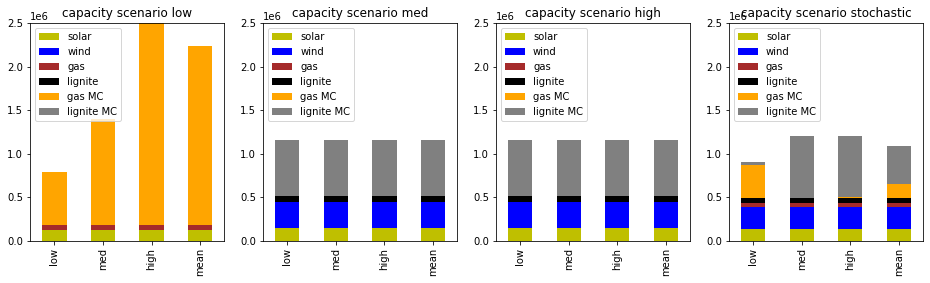

In [33]:
fig, axes = plt.subplots(1, len(results.index), figsize=(len(results.index)*4,4))

colors={"wind" : "b",
        "solar" : "y",
        "lignite": "black",
        "gas" : "brown",
        "gas MC" : "orange",
        "lignite MC" : "gray"}
    
#fig.suptitle('Horizontally stacked subplots')

for i,capacity_scenario in enumerate(results.index):
    ax = axes[i]
    
    df = pd.DataFrame(index=scenarios+["mean"])
    
    for tech in ["solar","wind","gas", "lignite"]:
        df[tech] = results.at[capacity_scenario,f"DE {tech} CC"]
    
    for scenario in scenarios+["mean"]:
        df.at[scenario,"gas MC"] = results.at[capacity_scenario,f"DE gas-{scenario} MC"]
        df.at[scenario,"lignite MC"] = results.at[capacity_scenario,f"DE lignite-{scenario} MC"]

    df.plot(kind="bar",stacked=True,ax=ax,color=colors)
    
    ax.set_title(f"capacity scenario {capacity_scenario}")
    
    ax.legend(loc="upper left")
    
    ax.set_ylim([0,2.5e6])


KeyError: 'lignite-mean'

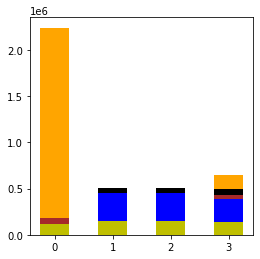

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))

df = results[["DE solar CC","DE wind CC","DE gas CC", "DE lignite CC", "DE gas-mean MC", "DE lignite-mean MC"]].rename(columns=lambda x: x[3:-3]).rename(columns={"gas-mean":"gas MC","gas-mean":"gas MC"})

df.plot(kind="bar",stacked=True,ax=ax,color=colors)

ax.set_xlabel("capacity scenario")

ax.set_title("means of results")
ax.set_ylim([0,2e6])

# The Expected costs of ignoring uncertainty (ECIU)

in some literature also defined as the Value of Stochastic Solution (VSS). Can be used interchangeably.

The natural question to ask is how much difference it really makes to the quality of the decisions reached if I use a stochastic problem instead of a deterministic problem?

The ECIU measures the value of using a stochastic model (or the expected costs of ignoring uncertainty when using a deterministic model).


In [ ]:
portfolios = pd.DataFrame()
costs = pd.Series()

### Define the naive problem (usually -- the expected value problem (EV))

In [209]:
# can be anything (e.g., the 'med' scenario). A texbook way is to take expected value of uncertain parameter.

naive_scenario = sum(pd.Series(gas_prices) * pd.Series(probability))
naive_scenario
#naive_scenario = gas_prices["med"]

170.0

### solve naive problem (deterministic)

In [ ]:
scenario='naive' #naive problem (in literature often EVP for Expected Value Problem, if the naive assumption is the expected value)
gas_price = naive_scenario

n = prepare_network(cts,gas_price)

n.optimize(solver_name = solver_name)

portfolios[scenario] = n.generators.p_nom_opt
costs[scenario] = n.objective

In [211]:
#pd.set_option("display.precision", 10)
portfolios
#costs

,naive
Generator,
DE solar,1.7019633365
DE wind,1.7135728680
DE gas,0.0000000000
DE lignite,0.9893107324


### solve stochastic problem

In [ ]:
scenario = "SP" #SP for Stochastic Problem
gas_price = gas_prices[base_scenario]

n = prepare_network(cts, gas_price)
prepare_stochastic_model(n)

n.optimize.solve_model(solver_name = solver_name)

portfolios[scenario] = n.generators.p_nom_opt
costs[scenario] = n.objective

In [246]:
portfolios

,naive,SP,SP-constrained
Generator,,,
DE solar,1.7019633365,1.5636567926,1.7019633365
DE wind,1.7135728680,1.4186811940,1.7135728680
DE gas,0.0000000000,0.8081063443,0.0000000000
DE lignite,0.9893107324,0.9393288843,0.9893107324


### Solve stochastic problem constrained by the naive solution 

In [ ]:
scenario = "SP-constrained"

gas_price = gas_prices[base_scenario]
n = prepare_network(cts, gas_price)
prepare_stochastic_model(n)

n.generators.p_nom_extendable = False
n.generators.p_nom = portfolios.loc[n.generators.index, "naive"]
#n.generators.T

n.optimize.solve_model(solver_name = solver_name)

In [248]:
# don't forget to add the capital costs of the (fixed) generators portfolio
c = "Generator"
ext_i = portfolios["naive"].index
cost = n.df(c)["capital_cost"][ext_i]
cost_of_portfolio = (n.generators.p_nom * cost).sum()
n.objective += cost_of_portfolio
n.objective

1590577.4809647123

In [249]:
portfolios[scenario] = n.generators.p_nom #just a fixed copy of naive problem's solution
costs[scenario] = n.objective #must be >= than the stochastic solution's costs, because you do dispatch with the suboptimal first-stage decisions

costs

naive             1.1504329342e+06
SP                1.0816050626e+06
SP-constrained    1.5905774810e+06
dtype: float64

### Compute ECIU

In [250]:
# ECIU (or VSS) in M euro
eciu = (costs["SP-constrained"] - costs["SP"])/1e6
# ECIU in % of stochastic solution
eciu_pp = eciu/(costs["SP"]/1e6)*100

print(f"ECIU: {round(eciu, 3)} Meuro \nwhich is {round(eciu_pp)}% of stochastic solution's costs")

ECIU: 0.509 Meuro 
which is 47% of stochastic solution's costs


# The Expected Value of Perfect Information (EVPI)

If system planner knew at the first stage which scenario will play out, it could optimize an expansion plan (i.e. that results in lower cost) for that scenario.

The expected value (and the corresponding mathematical problem) of such solution is denoted in the literature as „wait-and-see” solution (or wait-and-see (WS) problem).

The difference between the (probability-weighted) wait-and-see solutions and the here-and-now (stochastic) solution represents the added value of information about the future (i.e., the expected profit).

*modelling perspective*: How much the expected costs could be reduced if system planner in the first stage knew exactly which scenario would happen?

*economic perspective*: An upper bound to the amount that should be paid for improved forecasts.

In [251]:
portfolios = pd.DataFrame()
costs = pd.Series()

/tmp/ipykernel_486794/242555145.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  costs = pd.Series()


### Solve Wait-and-See problems
where Wait-and-See (WS) is a standard textbook name for individual determinic problem (i.e. running a single scenario).

In [ ]:
for scenario in scenarios:
    gas_price = gas_prices[scenario]
    n = prepare_network(cts,gas_price)

    n.optimize(solver_name = solver_name)
    
    if results is None:
        results = pd.DataFrame(columns=n.generators.index)
        results.index.name = "scenario"
    
    portfolios[scenario] = n.generators.p_nom_opt
    costs[scenario] = n.objective

### compute the expected value of wait-and-see scenario costs

In [257]:
ws = sum(costs * pd.Series(probability))

### solve stochastic problem

In [ ]:
scenario = "SP" #SP for Stochastic Problem
gas_price = gas_prices[base_scenario]

n = prepare_network(cts, gas_price)
prepare_stochastic_model(n)

n.optimize.solve_model(solver_name = solver_name)

portfolios[scenario] = n.generators.p_nom_opt
costs[scenario] = n.objective

### Compute EVPI

In [264]:
# EVPI in M euro
evpi = (costs["SP"] - ws)/1e6 #must be >=0 because improved information cannot make the decision maker worse
# ECIU in % of stochastic solution
evpi_pp = evpi/(costs["SP"]/1e6)*100

print(f"EVPI: {round(evpi, 3)} Meuro \nwhich is {round(evpi_pp)}% of stochastic solution's costs")

EVPI: 0.076 Meuro 
which is 7% of stochastic solution's costs


# Comparing the ECIU and EVPI metrics

ECIU: an investment decision is made when uncertainty is **ignored**. 
The ECIU is **the additional expected cost of assuming that future is certain**.

EVPI: an investment decision is made after uncertainty is **removed**.
The EVPI is the **expected cost of being uncertain about the future**.